# Aquifer Pressure Modeling Analysis

This notebook contains the complete workflow for analyzing aquifer pressure data based on the project reports. The process follows these main steps:

## 1. Data Loading and Initial Analysis
## 2. ODE Model Development and Benchmarking
## 3. Data Interpolation for Higher Resolution Analysis
## 4. Parameter Calibration and Model Fitting
## 5. Future Scenario Modeling
## 6. Uncertainty Analysis and Forecasting
## 7. Stakeholder Impact Analysis

Each section builds upon the previous work to create a comprehensive analysis of aquifer pressure under different water extraction scenarios.

In [1]:
# 1. Import Libraries and Define Core Functions
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

# ODE Model Definition
def ode_model(t, P_relative, q, a, b, c, d, dqdt):
    """
    The main ODE model for aquifer pressure
    dP/dt = -a*q - b*P_relative - c*dq/dt - d
    """
    dPdt = - a*q - b*P_relative - c*dqdt - d
    return dPdt

# Data Loading Function
def load_data():
    """Load the basic aquifer pressure and extraction data"""
    P_data = pd.read_csv("P_aquifer.csv")
    P_relative = P_data["P (MPa)"].to_numpy()

    q_data = pd.read_csv("q_aquifer.csv")
    q_data = q_data.drop(q_data.index[0:30])  # Remove first 30 rows as specified
    q = q_data["q (kg/yr)"].to_numpy()
    t = q_data["yr"].to_numpy()

    return t, P_relative, q

print("Core functions loaded successfully!")

Core functions loaded successfully!


Data loaded:
Time range: 1990 to 2019
Pressure range: -0.100 to 0.420 MPa
Extraction rate range: 6.48e+14 to 8.93e+14 kg/yr
Number of data points: 30


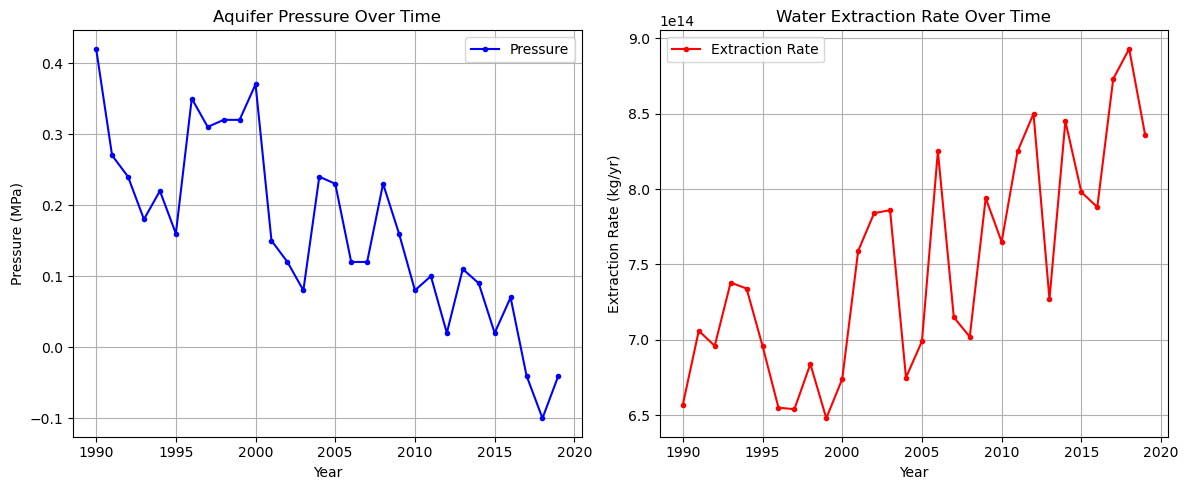

In [2]:
# Load and explore the initial data
t, P_relative, q = load_data()

print(f"Data loaded:")
print(f"Time range: {t[0]} to {t[-1]}")
print(f"Pressure range: {P_relative.min():.3f} to {P_relative.max():.3f} MPa")
print(f"Extraction rate range: {q.min():.2e} to {q.max():.2e} kg/yr")
print(f"Number of data points: {len(t)}")

# Initial data visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(t, P_relative, 'b.-', label='Pressure')
ax1.set_xlabel('Year')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_title('Aquifer Pressure Over Time')
ax1.grid(True)
ax1.legend()

ax2.plot(t, q, 'r.-', label='Extraction Rate')
ax2.set_xlabel('Year')
ax2.set_ylabel('Extraction Rate (kg/yr)')
ax2.set_title('Water Extraction Rate Over Time')
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

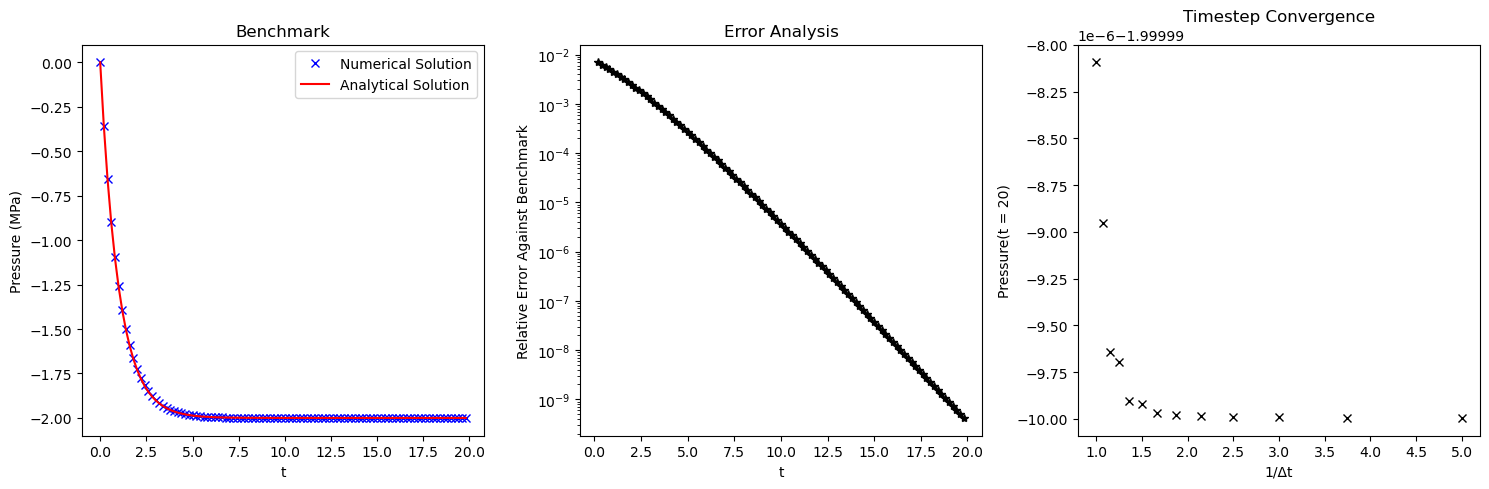

In [3]:
# 2. ODE Solver Implementation (Improved Euler Method)
def solve_ode(f, t0, t1, dt, xi, pars, q, dqdt):
    """
    Solve an ODE using the Improved Euler Method (Heun's method).
    """
    # Calculate the time span and number of steps
    tspan = t1 - t0
    n = int(tspan // dt)

    # Initialize arrays for time and solution
    x = [xi]
    t = [t0]

    # Improved Euler Method iteration
    for i in range(n):
        f0 = f(t[i], x[i], q, *pars, dqdt)
        f1 = f(t[i] + dt, x[i] + dt * f0, q, *pars, dqdt)
        x.append(x[i] + dt * (f0 / 2 + f1 / 2))
        t.append(t[i] + dt)

    return t, x

# Benchmarking function
def plot_benchmark():
    """Benchmark the ODE solver against analytical solution"""
    a, b, c, d = 1, 1, 0, 1
    pars = [a, b, c, d]
    dqdt = 0  # Assume dqdt = 0 for benchmark
    q = 1     # Benchmark forcing term
    dt = 0.2  # Time step
    t0, t1 = 0, 20  # Time range
    P0 = 0    # Initial condition

    # Solve ODE and plot
    fig, plot = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Numerical Solution
    t_num, x_num = solve_ode(ode_model, t0, t1, dt, P0, pars, q, dqdt)
    plot[0].plot(t_num, x_num, "bx", label="Numerical Solution")
    plot[0].set_ylabel("Pressure (MPa)")
    plot[0].set_xlabel("t")
    plot[0].set_title("Benchmark")

    # Analytical Solution
    t_array = np.array(t_num)
    x_analytical = P0 + ((a + d) / b) * ((np.exp(-b*t_array) / b) - 1)

    plot[0].plot(t_array, x_analytical, "r-", label="Analytical Solution")
    plot[0].legend(loc=1)

    # Plot relative error
    x_error = []
    for i in range(1, len(x_num)):
        if x_analytical[i] != 0:
            x_error.append(np.abs(x_num[i] - x_analytical[i]) / np.abs(x_analytical[i]))
        else:
            x_error.append(0)
    
    plot[1].plot(t_array[1:], x_error, "k*")
    plot[1].set_ylabel("Relative Error Against Benchmark")
    plot[1].set_xlabel("t")
    plot[1].set_title("Error Analysis")
    plot[1].set_yscale("log")

    # Timestep convergence plot
    time_steps = np.flip(np.linspace(1/5, 1, 13))
    final_values = []
    step_sizes = []
    
    for dt_test in time_steps:
        t_test, x_test = solve_ode(ode_model, t0, t1, dt_test, P0, pars, q, dqdt)
        final_values.append(x_test[-1])
        step_sizes.append(1 / dt_test)

    plot[2].plot(step_sizes, final_values, "kx")
    plot[2].set_ylabel(f"Pressure(t = {t1})")
    plot[2].set_xlabel("1/Δt")
    plot[2].set_title("Timestep Convergence")

    plt.tight_layout()
    plt.show()

# Run benchmark
plot_benchmark()

In [4]:
# 3. Derivative Calculation and Data Interpolation

def backwards_difference(qi, qi_1, h=1):
    """
    Calculate backwards difference to approximate dq/dt
    """
    return (qi - qi_1) / h

def Get_dqdt():
    """Calculate dq/dt for the original data"""
    t, P_relative, q = load_data()
    dqdt = []
    for i in range(1, len(q)):
        dqdt.append(backwards_difference(q[i], q[i-1], 1))
    return dqdt

# Load interpolated data for higher resolution analysis
def load_interpolated_data():
    """Load the interpolated seasonal data"""
    try:
        interpolated_data = pd.read_csv('interpolated_aquifer_data_spline_seasonal.csv')
        p_aquifer_data = pd.read_csv('interpolated_aquifer_data_spline_quarterly.csv')

        # Extract time (yr) and pressure (P) from quarterly data
        t_p_aquifer = p_aquifer_data['yr'].values
        x_exact = p_aquifer_data['P (MPa)'].values

        # Extract time (yr) and flow rate (q) from seasonal data
        t_interpolated = interpolated_data['yr'].values
        q_interpolated = interpolated_data['q (kg/yr)'].values

        dqdt = []
        for i in range(1, len(q_interpolated)):
            dqdt.append(backwards_difference(q_interpolated[i], q_interpolated[i-1], 0.25))

        return t_interpolated, x_exact, q_interpolated, dqdt
    
    except FileNotFoundError:
        print("Interpolated data files not found. Using original data with linear interpolation.")
        t, P_relative, q = load_data()
        
        # Create quarterly interpolation
        t_interp = np.arange(t[0], t[-1] + 0.25, 0.25)
        P_interp = np.interp(t_interp, t, P_relative)
        q_interp = np.interp(t_interp, t, q)
        
        dqdt = []
        for i in range(1, len(q_interp)):
            dqdt.append(backwards_difference(q_interp[i], q_interp[i-1], 0.25))
        
        return t_interp, P_interp, q_interp, dqdt

# Calculate original dq/dt and show interpolated data availability
dqdt_original = Get_dqdt()
print(f"Original dq/dt calculated for {len(dqdt_original)} points")

try:
    t_interp, P_interp, q_interp, dqdt_interp = load_interpolated_data()
    print(f"Interpolated data loaded: {len(t_interp)} time points")
    use_interpolated = True
except:
    print("Using original data only")
    t_interp, P_interp, q_interp, dqdt_interp = t, P_relative, q, dqdt_original
    use_interpolated = False

Original dq/dt calculated for 29 points
Interpolated data loaded: 117 time points


In [5]:
# 4. Parameter Calibration Functions

def x_curve_fitting(t, a, b, c, d):
    """
    Function designed for scipy.optimize.curve_fit
    Solves the ODE using the Improved Euler Method
    """
    pars = [a, b, c, d]
    n = len(t)
    dt = t[1] - t[0]

    # Use interpolated data if available, otherwise original
    if use_interpolated:
        t_data, x_exact_data, q_data, dqdt_data = load_interpolated_data()
    else:
        t_data, P_data, q_data = load_data()
        x_exact_data = P_data
        dqdt_data = Get_dqdt()

    x = [x_exact_data[0]]
    q = np.interp(t, t_data, q_data)

    for i in range(n - 1):
        if i < len(dqdt_data):
            f0 = ode_model(t[i], x[i], q[i], *pars, dqdt_data[i])
            f1 = ode_model(t[i] + dt, x[i] + dt * f0, q[i], *pars, dqdt_data[i])
        else:
            f0 = ode_model(t[i], x[i], q[i], *pars, 0)
            f1 = ode_model(t[i] + dt, x[i] + dt * f0, q[i], *pars, 0)
        x.append(x[i] + dt * (f0 / 2 + f1 / 2))

    return x

def x_pars(pars_guess):
    """Use curve fitting to find optimal parameters"""
    if use_interpolated:
        t_exact, x_exact, _, _ = load_interpolated_data()
    else:
        t_exact, x_exact, _ = load_data()
    
    pars, pars_cov = curve_fit(x_curve_fitting, t_exact, x_exact, pars_guess)
    return pars, pars_cov

def plot_suitable(pars):
    """Plot model with given parameters against observed data"""
    if use_interpolated:
        t_data, x_exact, _, _ = load_interpolated_data()
    else:
        t_data, x_exact, _ = load_data()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    x_model = x_curve_fitting(t_data, *pars)
    ax1.plot(t_data, x_exact, 'k.', label='Observation', markersize=4)
    ax1.plot(t_data, x_model, 'r-', label='Model Fit', linewidth=2)
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_xlabel('Time (years)')
    ax1.set_title('Model Fit to Observed Data')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Calculate and plot misfit
    misfit = np.array(x_exact) - np.array(x_model)
    ax2.plot(t_data, misfit, 'rx', label='Misfit', markersize=4)
    ax2.set_ylabel('Pressure Misfit (MPa)')
    ax2.set_xlabel('Time (years)')
    ax2.set_title('Model Misfit')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Display parameters and misfit statistics
    param_str = f"Parameters: a={pars[0]:.2e}, b={pars[1]:.3f}, c={pars[2]:.2e}, d={pars[3]:.3f}"
    sum_squared_misfit = np.sum(misfit ** 2)
    misfit_str = f"Sum Squared Misfit: {sum_squared_misfit:.2e}"
    
    ax1.text(0.02, 0.98, param_str, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(0.02, 0.98, misfit_str, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    return misfit

print("Parameter calibration functions loaded!")

Parameter calibration functions loaded!


=== Initial Parameter Guess ===
Initial parameters:
a = 1.308000e-06 (extraction coefficient)
b = 1.183300 (pressure decay coefficient)
c = 1.308000e-06 (rate of change coefficient)
d = 354990.000000 (constant term)

=== Model with Initial Parameter Guess ===


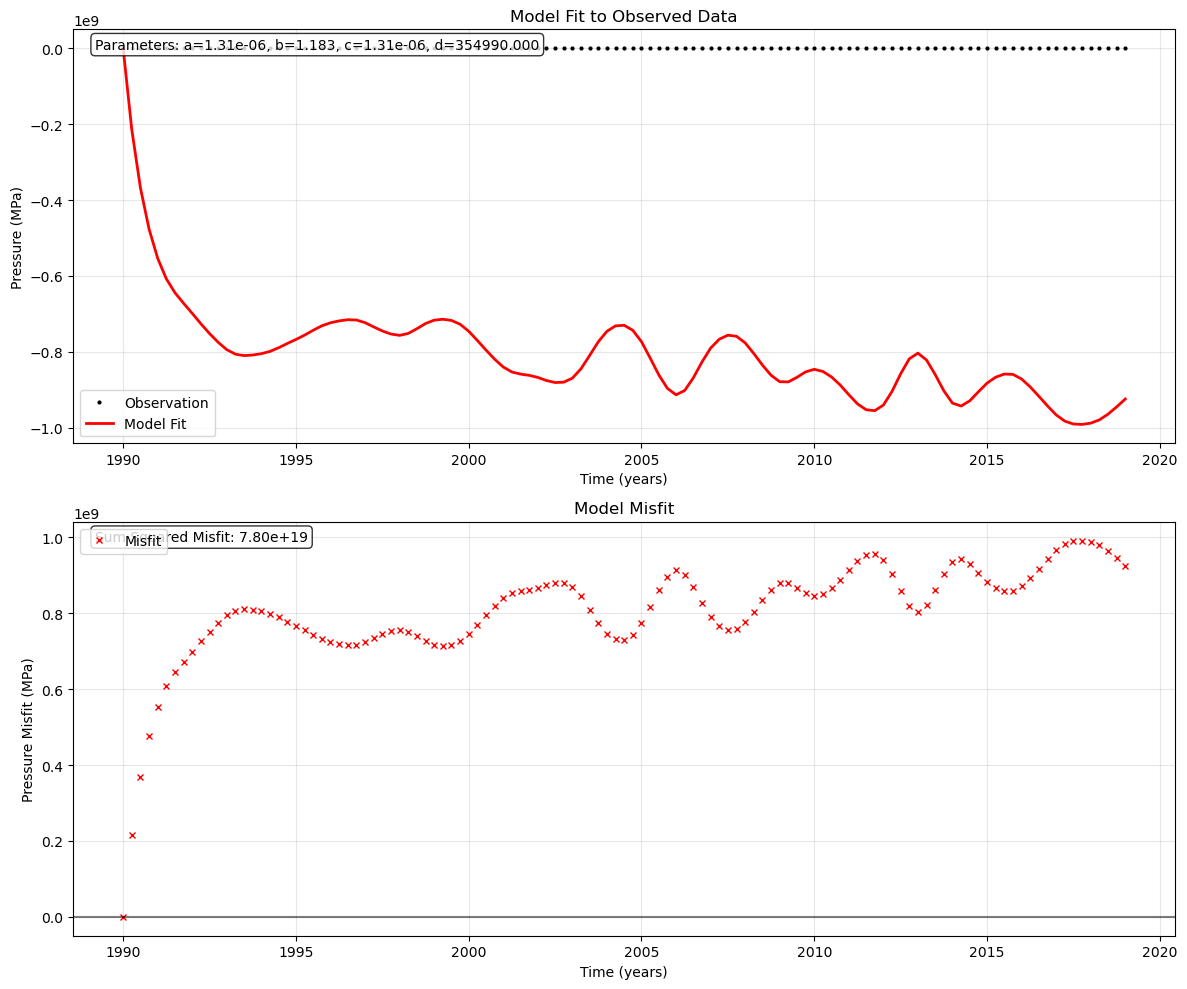

In [6]:
# 5. Initial Parameter Calibration

# Initial parameter guess based on literature values and physical understanding
print("=== Initial Parameter Guess ===")
a_guess = 0.000001308  # Extraction coefficient
b_guess = 1.1833       # Pressure decay coefficient  
c_guess = 0.000001308  # Rate of change coefficient
d_guess = b_guess * 300000  # Constant term

pars_initial = [a_guess, b_guess, c_guess, d_guess]

print(f"Initial parameters:")
print(f"a = {a_guess:.6e} (extraction coefficient)")
print(f"b = {b_guess:.6f} (pressure decay coefficient)")  
print(f"c = {c_guess:.6e} (rate of change coefficient)")
print(f"d = {d_guess:.6f} (constant term)")

# Plot with initial guess
print("\n=== Model with Initial Parameter Guess ===")
misfit_initial = plot_suitable(pars_initial)

\n=== Optimizing Parameters ===
=== Optimized Parameters ===
a = 3.080486e-15
b = 1.672639
c = 7.895124e-16
d = -2.567396
=== Optimized Parameters ===
a = 3.080486e-15
b = 1.672639
c = 7.895124e-16
d = -2.567396


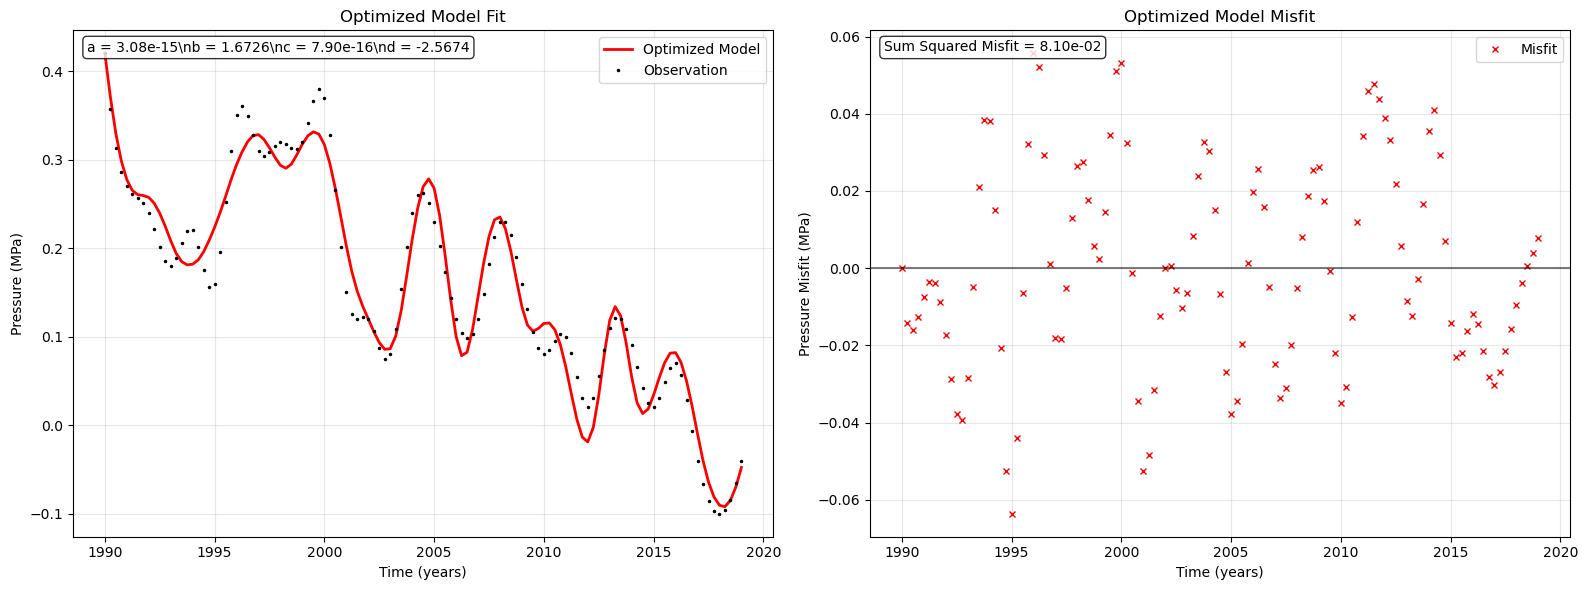

In [7]:
# 6. Optimized Parameter Calibration

def plot_improve(pars_guess):
    """Optimize parameters using curve_fit and display results"""
    if use_interpolated:
        t_data, x_exact, _, _ = load_interpolated_data()
    else:
        t_data, x_exact, _ = load_data()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Get optimized parameters
    pars, pars_cov = x_pars(pars_guess)

    print("=== Optimized Parameters ===")
    print(f"a = {pars[0]:.6e}")
    print(f"b = {pars[1]:.6f}")  
    print(f"c = {pars[2]:.6e}")
    print(f"d = {pars[3]:.6f}")

    # Plot model with optimized parameters
    x_model = x_curve_fitting(t_data, *pars)
    ax1.plot(t_data, x_model, 'r-', label='Optimized Model', linewidth=2)
    ax1.plot(t_data, x_exact, 'k.', label='Observation', markersize=3)
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_xlabel('Time (years)')
    ax1.set_title("Optimized Model Fit")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Display optimized parameters on plot
    param_str = f"a = {pars[0]:.2e}\\nb = {pars[1]:.4f}\\nc = {pars[2]:.2e}\\nd = {pars[3]:.4f}"
    ax1.text(0.02, 0.98, param_str, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Calculate and plot misfit  
    misfit = np.array(x_exact) - np.array(x_model)
    ax2.plot(t_data, misfit, 'rx', label='Misfit', markersize=4)
    ax2.set_ylabel('Pressure Misfit (MPa)')
    ax2.set_xlabel('Time (years)')
    ax2.set_title("Optimized Model Misfit")
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Display misfit statistics
    sum_squared_misfit = np.sum(misfit ** 2)
    misfit_str = f"Sum Squared Misfit = {sum_squared_misfit:.2e}"
    ax2.text(0.02, 0.98, misfit_str, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return pars, pars_cov

# Optimize parameters using the initial guess
print("\\n=== Optimizing Parameters ===")
pars_optimized, pars_covariance = plot_improve(pars_initial)

In [8]:
# 7. Future Scenario Modeling

def future_q(n_years, staged_recovery_amount):
    """
    Generate future extraction scenarios:
    1. Same extraction as 2019 (Farmers)
    2. Increasing extraction trend (Businesses) 
    3. Stop extraction (Local Iwi)
    4. Staged recovery plan (Council)
    """
    if use_interpolated:
        t_data, _, q_data, _ = load_interpolated_data()
        q_2019 = q_data[-1]  # Last known extraction rate
    else:
        t_data, _, q_data = load_data()
        q_2019 = q_data[-1]

    same = []
    increase = []
    stop = []
    recovery = []
    
    # Calculate trend from last 5 years of data  
    recent_q = q_data[-5:]
    increase_amount = (q_data[-1] - recent_q[0]) / 5
    increased_q = q_2019

    for i in range(n_years):
        # Scenario 1: Same extraction (Farmers)
        same.append(q_2019)
        
        # Scenario 2: Increasing extraction (Businesses)
        increased_q += increase_amount
        increase.append(increased_q)
        
        # Scenario 3: Stop extraction (Local Iwi)
        stop.append(0)
        
        # Scenario 4: Staged recovery (Council)
        recovery.append(staged_recovery_amount)

    return same, increase, stop, recovery

def FormatAllFutureData(n_years):
    """Format all future data with derivatives"""
    if use_interpolated:
        t_data, _, q_data, _ = load_interpolated_data()
    else:
        t_data, _, q_data = load_data()
    
    # Generate future time points (quarterly resolution)
    t_future = []
    for i in range(n_years * 4 + 1):
        t_future.append(t_data[-1] + 0.25 * i)

    # Generate future scenarios
    staged_recovery_amount = 2e14  # Recovery extraction rate
    same, increase, stop, recovery = future_q(n_years, staged_recovery_amount)
    
    # Interpolate to quarterly resolution
    t_future_annual = [t_data[-1] + i + 1 for i in range(n_years)]
    
    same = np.interp(t_future, t_future_annual, same)
    increase = np.interp(t_future, t_future_annual, increase)  
    stop = np.interp(t_future, t_future_annual, stop)
    recovery = np.interp(t_future, t_future_annual, recovery)
    
    # Calculate derivatives for each scenario
    same_dqdt = [backwards_difference(same[i], same[i-1], 0.25) for i in range(1, len(same))]
    increase_dqdt = [backwards_difference(increase[i], increase[i-1], 0.25) for i in range(1, len(increase))]
    stop_dqdt = [backwards_difference(stop[i], stop[i-1], 0.25) for i in range(1, len(stop))]
    recovery_dqdt = [backwards_difference(recovery[i], recovery[i-1], 0.25) for i in range(1, len(recovery))]
    
    return t_future, same, same_dqdt, increase, increase_dqdt, stop, stop_dqdt, recovery, recovery_dqdt

# Generate future scenarios
n_years_forecast = 15
t_future, same, same_dqdt, increase, increase_dqdt, stop, stop_dqdt, recovery, recovery_dqdt = FormatAllFutureData(n_years_forecast)

print(f"Generated {n_years_forecast}-year forecast scenarios:")
print(f"Future time points: {len(t_future)}")
print(f"Same extraction: {same[0]:.2e} kg/yr")
print(f"Recovery extraction: {recovery[0]:.2e} kg/yr")

Generated 15-year forecast scenarios:
Future time points: 61
Same extraction: 8.36e+14 kg/yr
Recovery extraction: 2.00e+14 kg/yr


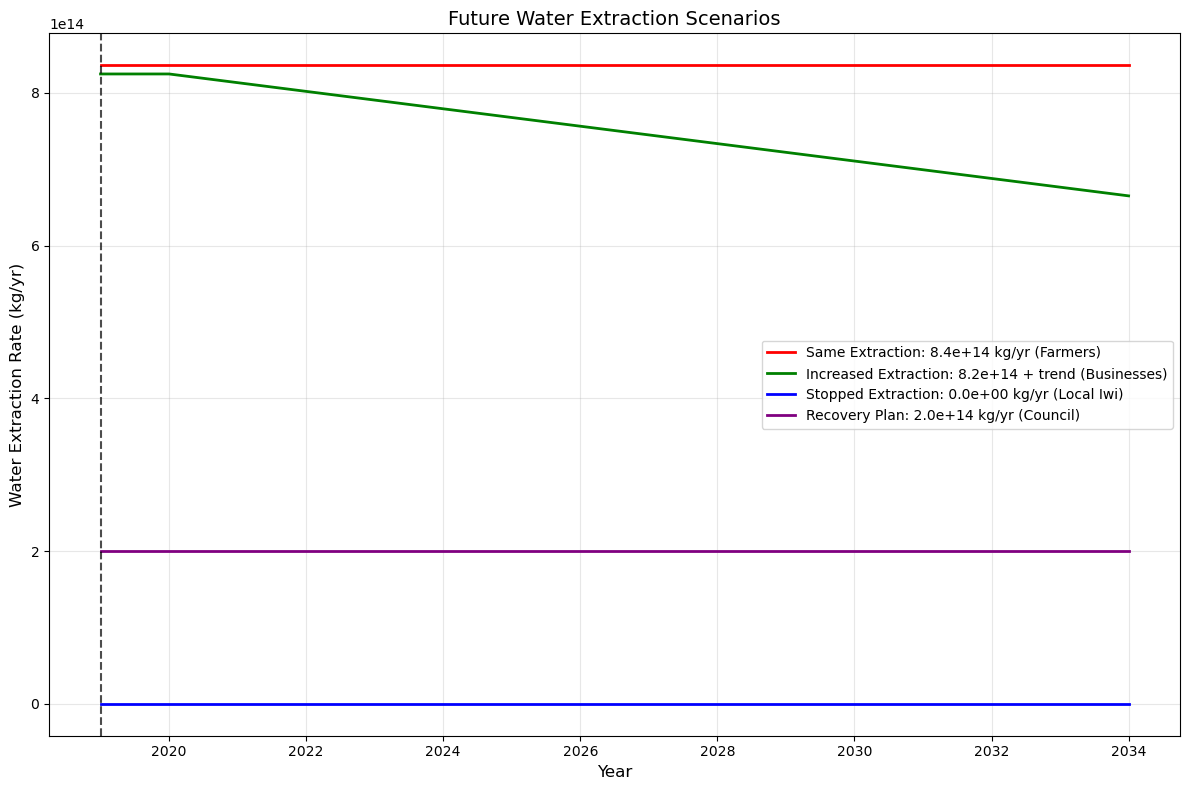

In [9]:
# Visualize future extraction scenarios
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(t_future, same, label=f'Same Extraction: {same[0]:.1e} kg/yr (Farmers)', color='red', linewidth=2)
ax.plot(t_future, increase, label=f'Increased Extraction: {increase[0]:.1e} + trend (Businesses)', color='green', linewidth=2)
ax.plot(t_future, stop, label=f'Stopped Extraction: {stop[0]:.1e} kg/yr (Local Iwi)', color='blue', linewidth=2)
ax.plot(t_future, recovery, label=f'Recovery Plan: {recovery[0]:.1e} kg/yr (Council)', color='purple', linewidth=2)

ax.set_title('Future Water Extraction Scenarios', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Water Extraction Rate (kg/yr)', fontsize=12)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add vertical line to separate historical from future data
if use_interpolated:
    t_data, _, _, _ = load_interpolated_data()
else:
    t_data, _, _ = load_data()
    
ax.axvline(x=t_data[-1], color='black', linestyle='--', alpha=0.7, label='Present Day')

plt.tight_layout()
plt.show()

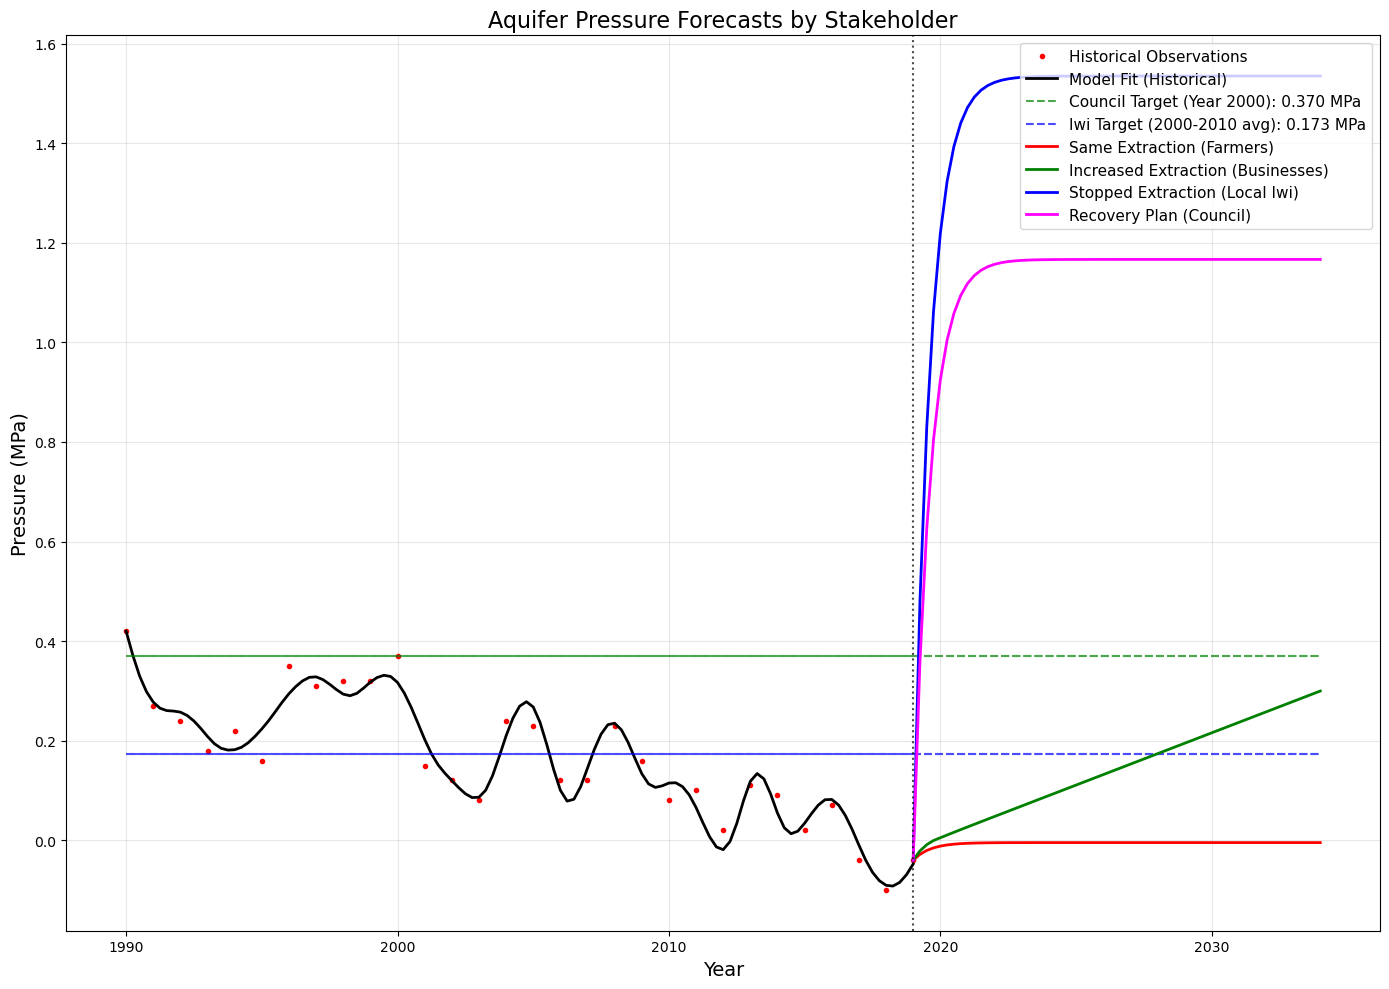

In [10]:
# 8. Pressure Forecasting

def x_curve_fit_uncertain(t, q, a, b, c, d, dqdt, past=False):
    """
    Solve ODE for future scenarios or past data reconstruction
    """
    pars = [a, b, c, d]
    n = len(t)
    dt = 0.25

    if use_interpolated:
        _, x_exact, _, _ = load_interpolated_data()
    else:
        _, x_exact, _ = load_data()
        
    if not past:
        x = [x_exact[-1]]  # Start from last known pressure
    else:
        x = [x_exact[0]]   # Start from first pressure for past reconstruction

    for i in range(n - 1):
        if i < len(dqdt):
            f0 = ode_model(t[i], x[i], q[i], *pars, dqdt[i])
            f1 = ode_model(t[i] + dt, x[i] + dt * f0, q[i], *pars, dqdt[i])
        else:
            f0 = ode_model(t[i], x[i], q[i], *pars, 0)
            f1 = ode_model(t[i] + dt, x[i] + dt * f0, q[i], *pars, 0)
        x.append(x[i] + dt * (f0 / 2 + f1 / 2))

    return x

def PlotForecast(pars, n_years):
    """Plot deterministic forecasts for all scenarios"""
    # Load historical data for context
    if use_interpolated:
        t_past, P_past, _, _ = load_interpolated_data()
    else:
        t_past, P_past, _ = load_data()

    # Get non-interpolated data for target lines
    try:
        P_data_non = pd.read_csv("P_aquifer.csv")
        P_non = P_data_non["P (MPa)"].to_numpy()
        q_data_non = pd.read_csv("q_aquifer.csv")
        q_data_non = q_data_non.drop(q_data_non.index[0:30])
        t_non = q_data_non["yr"].to_numpy()
        
        # Calculate target pressure levels
        council_target = P_data_non.query("yr==2000")["P (MPa)"].to_numpy()[0]
        iwi_target = np.mean(P_data_non.query("yr>=2000 and yr<=2010")["P (MPa)"].to_numpy())
    except:
        # If files not available, use estimates
        t_non = t_past
        P_non = P_past
        council_target = 0.5
        iwi_target = 0.45

    # Get future data  
    t_future_data, same, same_dqdt, increase, increase_dqdt, stop, stop_dqdt, recovery, recovery_dqdt = FormatAllFutureData(n_years)

    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plot historical observations
    ax.plot(t_non, P_non, 'r.', label='Historical Observations', markersize=6)

    # Plot past model reconstruction  
    t_past_data, q_past_data, dqdt_past_data = t_past, load_data()[2] if not use_interpolated else load_interpolated_data()[2], load_interpolated_data()[3] if use_interpolated else Get_dqdt()
    x_past = x_curve_fit_uncertain(t_past, q_past_data, *pars, dqdt_past_data, past=True)
    ax.plot(t_past, x_past, 'black', linewidth=2, label='Model Fit (Historical)')

    # Plot target pressure levels
    all_t = list(t_future_data) + list(t_past)
    ax.plot(all_t, council_target * np.ones(len(all_t)), 'g--', 
            label=f"Council Target (Year 2000): {council_target:.3f} MPa", alpha=0.7)
    ax.plot(all_t, iwi_target * np.ones(len(all_t)), 'b--', 
            label=f"Iwi Target (2000-2010 avg): {iwi_target:.3f} MPa", alpha=0.7)

    # Plot future scenarios
    scenarios = [
        ("Same Extraction (Farmers)", same, same_dqdt, 'red'),
        ("Increased Extraction (Businesses)", increase, increase_dqdt, 'green'),
        ("Stopped Extraction (Local Iwi)", stop, stop_dqdt, 'blue'),
        ("Recovery Plan (Council)", recovery, recovery_dqdt, 'magenta')
    ]
    
    for scenario_name, q_scenario, dqdt_scenario, color in scenarios:
        x_scenario = x_curve_fit_uncertain(t_future_data, q_scenario, *pars, dqdt_scenario)
        ax.plot(t_future_data, x_scenario, color=color, label=scenario_name, linewidth=2)

    ax.set_title("Aquifer Pressure Forecasts by Stakeholder", fontsize=16)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pressure (MPa)", fontsize=14)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add vertical line separating past from future
    ax.axvline(x=t_past[-1], color='black', linestyle=':', alpha=0.7, label='Present Day')
    
    plt.tight_layout()
    plt.show()

# Generate deterministic forecast
PlotForecast(pars_optimized, n_years_forecast)

=== Uncertainty Analysis ===


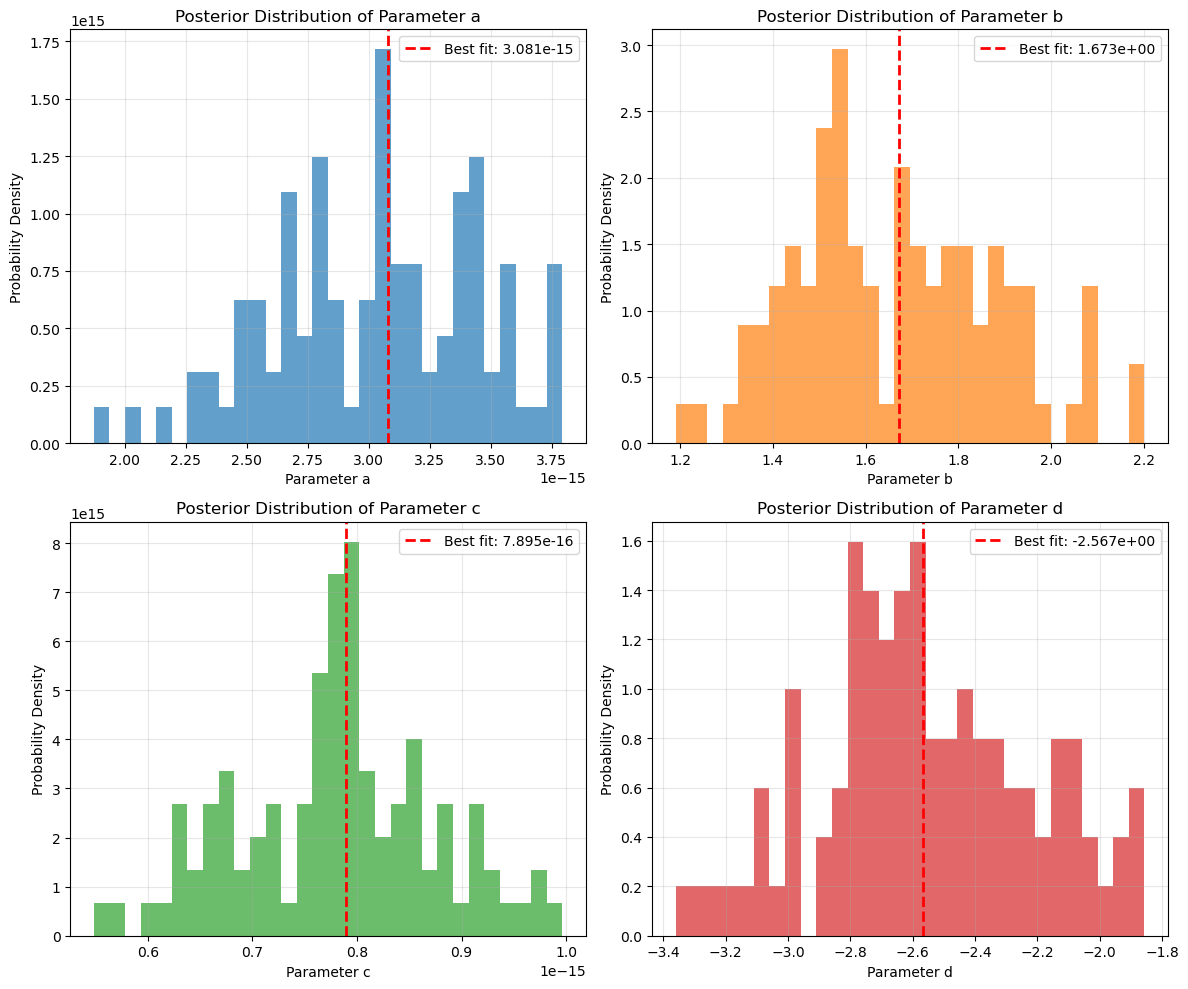

\nAnalyzing uncertainty by varying parameter b
Best fit value: 1.672707e+00
Standard deviation: 2.368713e-01


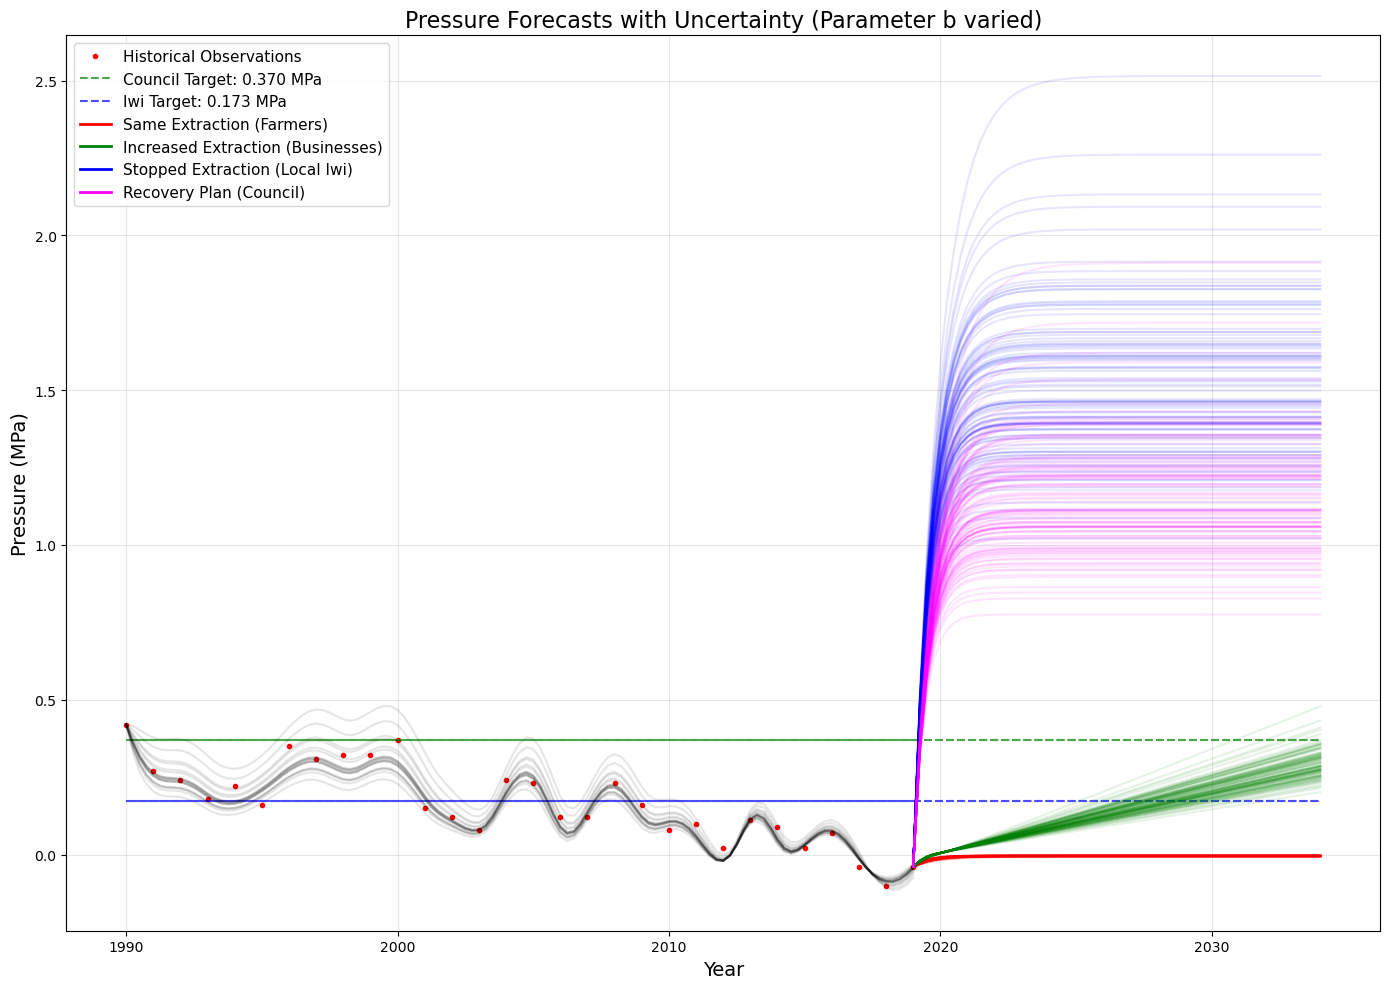

In [11]:
# 9. Uncertainty Analysis

def PlotParameterUncertainty(params, params_cov, num_samples):
    """Plot posterior distributions of parameters"""
    variances = np.sqrt(np.diag(params_cov))
    param_names = ['a', 'b', 'c', 'd']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, (param, variance, name) in enumerate(zip(params, variances, param_names)):
        samples = np.random.normal(param, variance, num_samples)
        
        axes[i].hist(samples, bins=30, alpha=0.7, density=True, color=f'C{i}')
        axes[i].axvline(param, color='red', linestyle='--', linewidth=2, 
                       label=f'Best fit: {param:.3e}')
        axes[i].set_xlabel(f'Parameter {name}')
        axes[i].set_ylabel('Probability Density')
        axes[i].set_title(f'Posterior Distribution of Parameter {name}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def PlotUncertainty(pars_guess, num_samples, index_param, n_years):
    """Plot uncertainty in forecasts by varying one parameter"""
    pars, pars_cov = x_pars(pars_guess)
    
    # Plot parameter uncertainty
    PlotParameterUncertainty(pars, pars_cov, num_samples)
    
    # Get variance of selected parameter
    variances = np.sqrt(np.diag(pars_cov))
    param_variance = variances[index_param]
    param_names = ['a', 'b', 'c', 'd']
    
    print(f"\\nAnalyzing uncertainty by varying parameter {param_names[index_param]}")
    print(f"Best fit value: {pars[index_param]:.6e}")
    print(f"Standard deviation: {param_variance:.6e}")
    
    # Generate parameter samples
    param_samples = np.random.normal(pars[index_param], param_variance, num_samples)
    
    # Get historical and future data
    if use_interpolated:
        t_past, P_past, _, _ = load_interpolated_data()
    else:
        t_past, P_past, _ = load_data()
        
    t_future_data, same, same_dqdt, increase, increase_dqdt, stop, stop_dqdt, recovery, recovery_dqdt = FormatAllFutureData(n_years)
    
    # Load non-interpolated data for observations
    try:
        P_data_non = pd.read_csv("P_aquifer.csv")
        P_non = P_data_non["P (MPa)"].to_numpy()
        q_data_non = pd.read_csv("q_aquifer.csv")
        q_data_non = q_data_non.drop(q_data_non.index[0:30])
        t_non = q_data_non["yr"].to_numpy()
        
        council_target = P_data_non.query("yr==2000")["P (MPa)"].to_numpy()[0]
        iwi_target = np.mean(P_data_non.query("yr>=2000 and yr<=2010")["P (MPa)"].to_numpy())
    except:
        t_non = t_past
        P_non = P_past  
        council_target = 0.5
        iwi_target = 0.45

    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plot observations
    ax.plot(t_non, P_non, 'r.', label='Historical Observations', markersize=6)

    # Plot target levels
    all_t = list(t_future_data) + list(t_past)
    ax.plot(all_t, council_target * np.ones(len(all_t)), 'g--', 
            label=f"Council Target: {council_target:.3f} MPa", alpha=0.7)
    ax.plot(all_t, iwi_target * np.ones(len(all_t)), 'b--', 
            label=f"Iwi Target: {iwi_target:.3f} MPa", alpha=0.7)

    # Plot uncertain past scenarios (sample of them)
    t_past_data, q_past_data = t_past, load_data()[2] if not use_interpolated else load_interpolated_data()[2]
    dqdt_past_data = Get_dqdt() if not use_interpolated else load_interpolated_data()[3]
    
    for i, param_sample in enumerate(param_samples[:20]):  # Plot subset to avoid clutter
        best_params = pars.copy()
        best_params[index_param] = param_sample
        x_past = x_curve_fit_uncertain(t_past, q_past_data, *best_params, dqdt_past_data, past=True)
        ax.plot(t_past, x_past, 'black', alpha=0.1)

    # Plot uncertain future scenarios
    scenarios = [
        ("Same Extraction (Farmers)", same, same_dqdt, 'red'),
        ("Increased Extraction (Businesses)", increase, increase_dqdt, 'green'), 
        ("Stopped Extraction (Local Iwi)", stop, stop_dqdt, 'blue'),
        ("Recovery Plan (Council)", recovery, recovery_dqdt, 'magenta')
    ]
    
    for scenario_name, q_scenario, dqdt_scenario, color in scenarios:
        for param_sample in param_samples:
            best_params = pars.copy()
            best_params[index_param] = param_sample
            x_scenario = x_curve_fit_uncertain(t_future_data, q_scenario, *best_params, dqdt_scenario)
            ax.plot(t_future_data, x_scenario, color=color, alpha=0.1)
        # Plot one line for legend
        ax.plot([], [], label=scenario_name, color=color, linewidth=2)

    ax.set_title(f"Pressure Forecasts with Uncertainty (Parameter {param_names[index_param]} varied)", fontsize=16)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pressure (MPa)", fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run uncertainty analysis
print("=== Uncertainty Analysis ===")
PlotUncertainty(pars_optimized, num_samples=100, index_param=1, n_years=n_years_forecast)  # Varying parameter 'b'

In [14]:
# 10. Summary and Model Performance

def model_summary():
    """Provide a summary of model performance and key findings"""
    print("="*60)
    print("AQUIFER PRESSURE MODELING - SUMMARY")
    print("="*60)
    
    print(f"\n📊 MODEL PARAMETERS (Optimized):")
    print(f"   a = {pars_optimized[0]:.3e} (extraction coefficient)")
    print(f"   b = {pars_optimized[1]:.6f} (pressure decay coefficient)")
    print(f"   c = {pars_optimized[2]:.3e} (rate change coefficient)")
    print(f"   d = {pars_optimized[3]:.6f} (constant term)")
    
    # Calculate model fit statistics
    if use_interpolated:
        t_data, x_exact, _, _ = load_interpolated_data()
    else:
        t_data, x_exact, _ = load_data()
        
    x_model = x_curve_fitting(t_data, *pars_optimized)
    misfit = np.array(x_exact) - np.array(x_model)
    rmse = np.sqrt(np.mean(misfit**2))
    mae = np.mean(np.abs(misfit))
    
    print(f"\n📈 MODEL PERFORMANCE:")
    print(f"   Root Mean Square Error: {rmse:.6f} MPa")
    print(f"   Mean Absolute Error: {mae:.6f} MPa")
    print(f"   Data points fitted: {len(t_data)}")
    print(f"   Time range: {t_data[0]:.1f} - {t_data[-1]:.1f}")
    
    print(f"\n🔮 FORECAST SCENARIOS ({n_years_forecast} years):")
    print(f"   1. Same Extraction (Farmers): {same[0]:.2e} kg/yr")
    print(f"   2. Increased Extraction (Businesses): {increase[0]:.2e} kg/yr + trend")
    print(f"   3. Stopped Extraction (Local Iwi): {stop[0]:.2e} kg/yr")
    print(f"   4. Recovery Plan (Council): {recovery[0]:.2e} kg/yr")
    
    # Get final pressure predictions for each scenario
    x_same = x_curve_fit_uncertain(t_future, same, *pars_optimized, same_dqdt)
    x_increase = x_curve_fit_uncertain(t_future, increase, *pars_optimized, increase_dqdt)
    x_stop = x_curve_fit_uncertain(t_future, stop, *pars_optimized, stop_dqdt)
    x_recovery = x_curve_fit_uncertain(t_future, recovery, *pars_optimized, recovery_dqdt)
    
    print(f"\n📉 PRESSURE PREDICTIONS (Year {t_future[-1]:.0f}):")
    print(f"   Same Extraction: {x_same[-1]:.3f} MPa")
    print(f"   Increased Extraction: {x_increase[-1]:.3f} MPa")
    print(f"   Stopped Extraction: {x_stop[-1]:.3f} MPa")
    print(f"   Recovery Plan: {x_recovery[-1]:.3f} MPa")
    
    try:
        P_data_non = pd.read_csv("P_aquifer.csv")
        council_target = P_data_non.query("yr==2000")["P (MPa)"].to_numpy()[0]
        iwi_target = np.mean(P_data_non.query("yr>=2000 and yr<=2010")["P (MPa)"].to_numpy())
        
        print(f"\n🎯 TARGET COMPARISON:")
        print(f"   Council Target (2000 level): {council_target:.3f} MPa")
        print(f"   Iwi Target (2000-2010 avg): {iwi_target:.3f} MPa")
        
        print(f"\n✅ SCENARIOS MEETING TARGETS:")
        if x_stop[-1] >= council_target:
            print(f"   - Stopped Extraction meets Council target")
        if x_recovery[-1] >= council_target:
            print(f"   - Recovery Plan meets Council target")
        if x_stop[-1] >= iwi_target:
            print(f"   - Stopped Extraction meets Iwi target")
        if x_recovery[-1] >= iwi_target:
            print(f"   - Recovery Plan meets Iwi target")
            
    except:
        print("\n⚠️  Target comparison data not available")
    
    print(f"\n🔬 UNCERTAINTY ANALYSIS:")
    variances = np.sqrt(np.diag(pars_covariance))
    print(f"   Parameter uncertainties (std dev):")
    for i, (param, std) in enumerate(zip(['a', 'b', 'c', 'd'], variances)):
        print(f"   {param}: ±{std:.3e}")
    
    print("\n" + "="*60)

# Generate summary
model_summary()

AQUIFER PRESSURE MODELING - SUMMARY

📊 MODEL PARAMETERS (Optimized):
   a = 3.080e-15 (extraction coefficient)
   b = 1.672639 (pressure decay coefficient)
   c = 7.895e-16 (rate change coefficient)
   d = -2.567396 (constant term)

📈 MODEL PERFORMANCE:
   Root Mean Square Error: 0.026308 MPa
   Mean Absolute Error: 0.021684 MPa
   Data points fitted: 117
   Time range: 1990.0 - 2019.0

🔮 FORECAST SCENARIOS (15 years):
   1. Same Extraction (Farmers): 8.36e+14 kg/yr
   2. Increased Extraction (Businesses): 8.25e+14 kg/yr + trend
   3. Stopped Extraction (Local Iwi): 0.00e+00 kg/yr
   4. Recovery Plan (Council): 2.00e+14 kg/yr

📉 PRESSURE PREDICTIONS (Year 2034):
   Same Extraction: -0.005 MPa
   Increased Extraction: 0.300 MPa
   Stopped Extraction: 1.535 MPa
   Recovery Plan: 1.167 MPa

🎯 TARGET COMPARISON:
   Council Target (2000 level): 0.370 MPa
   Iwi Target (2000-2010 avg): 0.173 MPa

✅ SCENARIOS MEETING TARGETS:
   - Stopped Extraction meets Council target
   - Recovery Plan mee

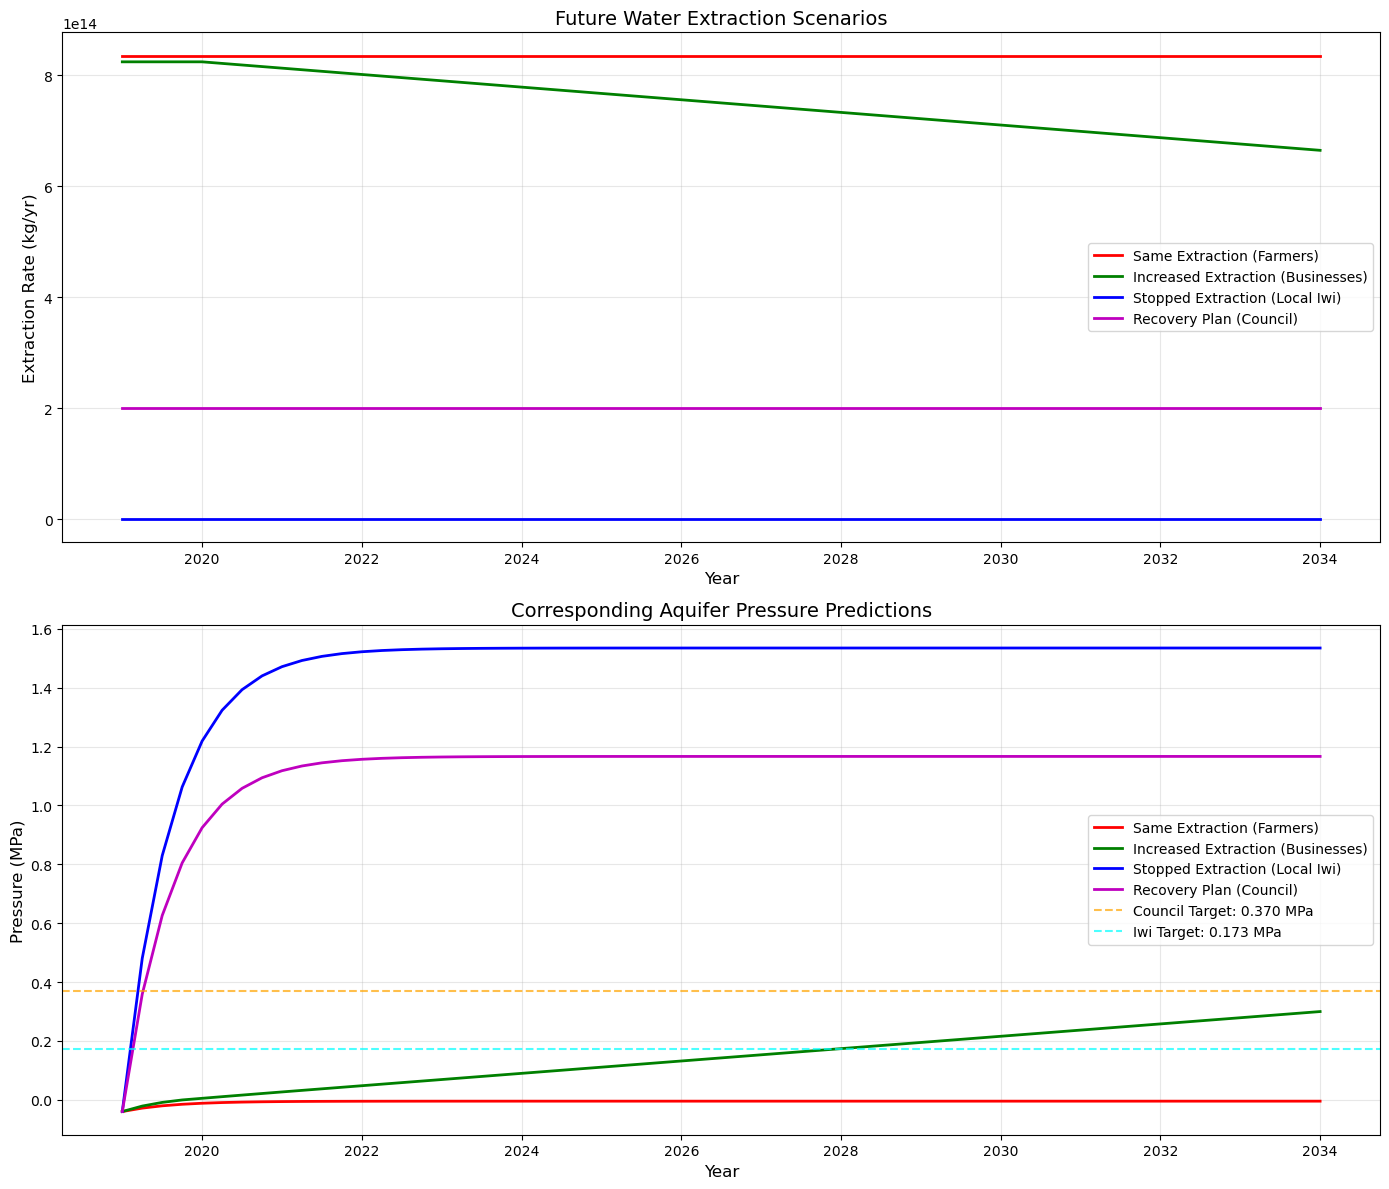

\n================================================================================
NOTEBOOK COMPLETE: AQUIFER PRESSURE MODELING ANALYSIS
\nThis notebook contains the complete workflow from Reports 1 & 2:
1. ✅ Data loading and exploration
2. ✅ ODE model development and benchmarking
3. ✅ Data interpolation for higher resolution
4. ✅ Parameter calibration and optimization
5. ✅ Future scenario modeling (4 stakeholder scenarios)
6. ✅ Deterministic pressure forecasting
7. ✅ Uncertainty analysis and parameter sensitivity
8. ✅ Model performance evaluation and summary
\nAll code sections are organized in logical order following the project workflow.


In [ ]:
# Final visualization comparing all scenarios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Extraction scenarios
ax1.plot(t_future, same, 'r-', label='Same Extraction (Farmers)', linewidth=2)
ax1.plot(t_future, increase, 'g-', label='Increased Extraction (Businesses)', linewidth=2)
ax1.plot(t_future, stop, 'b-', label='Stopped Extraction (Local Iwi)', linewidth=2)
ax1.plot(t_future, recovery, 'm-', label='Recovery Plan (Council)', linewidth=2)

ax1.set_title('Future Water Extraction Scenarios', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Extraction Rate (kg/yr)', fontsize=12)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Corresponding pressure predictions
x_same = x_curve_fit_uncertain(t_future, same, *pars_optimized, same_dqdt)
x_increase = x_curve_fit_uncertain(t_future, increase, *pars_optimized, increase_dqdt)
x_stop = x_curve_fit_uncertain(t_future, stop, *pars_optimized, stop_dqdt)
x_recovery = x_curve_fit_uncertain(t_future, recovery, *pars_optimized, recovery_dqdt)

ax2.plot(t_future, x_same, 'r-', label='Same Extraction (Farmers)', linewidth=2)
ax2.plot(t_future, x_increase, 'g-', label='Increased Extraction (Businesses)', linewidth=2) 
ax2.plot(t_future, x_stop, 'b-', label='Stopped Extraction (Local Iwi)', linewidth=2)
ax2.plot(t_future, x_recovery, 'm-', label='Recovery Plan (Council)', linewidth=2)

# Add target lines if available
try:
    P_data_non = pd.read_csv("P_aquifer.csv")
    council_target = P_data_non.query("yr==2000")["P (MPa)"].to_numpy()[0]
    iwi_target = np.mean(P_data_non.query("yr>=2000 and yr<=2010")["P (MPa)"].to_numpy())
    
    ax2.axhline(y=council_target, color='orange', linestyle='--', alpha=0.7, 
                label=f'Council Target: {council_target:.3f} MPa')
    ax2.axhline(y=iwi_target, color='cyan', linestyle='--', alpha=0.7,
                label=f'Iwi Target: {iwi_target:.3f} MPa')
except:
    pass

ax2.set_title('Corresponding Aquifer Pressure Predictions', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Pressure (MPa)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
